In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## Dataset Loader

In [3]:
import os, re, scipy.io
import numpy as np
from collections import Counter
from PIL import Image
import time

data_path = '/content/drive/MyDrive/Graduate School/Summer/CS 677/DATASET'
class DatasetLoader(torch.utils.data.Dataset):
    """ Dataset loader class that loads feature matrices from given paths and
        create shuffled batch for training, unshuffled batch for evaluation.
    """
    def __init__(self, split='train', transform=None):
      self.transform = transform
      if split == 'train':
        self.data_path = os.path.join(data_path, 'TRAIN')
      else:
        self.data_path = os.path.join(data_path, 'TEST')
      
      self.labels = []
      self.files = []
      for label in ['O', 'R']:
        
        for f in os.listdir(os.path.join(self.data_path, label)):
          if os.path.isfile(os.path.join(self.data_path, label, f)):
            self.files.append(os.path.join(label, f))
            self.labels.append(0 if label == 'O' else 1)

    def __len__(self):
      return len(self.files)

    def load_image(self, fn):
      image = Image.open(fn).convert("RGB")
      if self.transform:
          image = self.transform(image)
      return image

    def __getitem__(self, index):
      f = self.files[index]
      image = self.load_image(os.path.join(self.data_path, f))
      return image, torch.tensor(self.labels[index])

BATCH_SIZE = 12

## transformations
transform = transforms.Compose(
    [transforms.Resize([256, 256]),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

## download and load training dataset
trainloader = torch.utils.data.DataLoader(DatasetLoader(transform=transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testloader = torch.utils.data.DataLoader(DatasetLoader('test', transform), batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1])


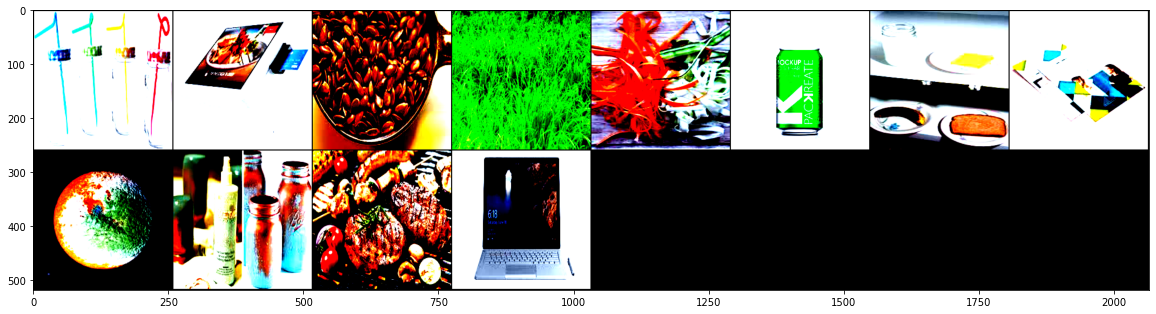

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
## show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [5]:
import torchvision.models as models

class ImageClassifier(nn.Module):
  def __init__(self, base_model):
    super(ImageClassifier, self).__init__()

    feature_size = 1
    if base_model == 'resnet':
      base = models.resnet18(pretrained=True)
      hidden_size = 512
    elif base_model == 'vgg':
      base = models.vgg19(pretrained=True)
      hidden_size = 25088
    elif base_model == 'alexnet':
      base = models.alexnet(pretrained=True)
      hidden_size = 9216
    else:
      raise 'Invalid model type'
    self.base_model = torch.nn.Sequential(*(list(base.children())[:-1]), nn.Flatten())
    self.fc = nn.Linear(hidden_size, feature_size)
    self.act = nn.Sigmoid()

  def forward(self, image):
    x = self.base_model(image)
    x = self.fc(x)
    return self.act(x)

In [ ]:
#from torchsummary import summary
#clf = ImageClassifier('alexnet')
#summary(clf, (3, 256, 256))

## VGG

In [26]:
learning_rate = .0001
epochs = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base = 'vgg'
model_path = '/content/drive/MyDrive/Graduate School/Summer/CS 677/vgg.model'

model = ImageClassifier(base)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.BCELoss()

def test_model(model, dataloader):
  num_total = 0.
  num_correct = 0.
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1))
    preds = torch.where(model(images) > .5, 1, 0)
    num_total += len(labels)
    num_correct += (preds == labels).sum()
  accuracy = 100. * num_correct / num_total
  return accuracy.item()

In [27]:
for epoch in range(epochs):
  model = model.train()
  running_loss = 0.
  count = 0
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1))
    labels = labels.type(torch.float)

    output = model(images)
    output = output.type(torch.float)
    output_loss = loss(output, labels)

    optimizer.zero_grad()
    output_loss.backward()

    optimizer.step()
    running_loss += output_loss.detach().item()
    count += 1
  
  model.eval()
  print('Epoch: {} | Loss: {:.4f}'.format(epoch, running_loss / count))
test_acc = test_model(model, testloader)
print('Test Accuracy: {:.3f}'.format(test_acc))
torch.save(model, model_path)

  0%|          | 0/1881 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.2301


  0%|          | 0/1881 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.1800


  0%|          | 0/210 [00:00<?, ?it/s]

Test Accuracy: 90.728


## ResNet

In [13]:
base = 'resnet'
model_path = '/content/drive/MyDrive/Graduate School/Summer/CS 677/resnet.model'

model = ImageClassifier(base)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.BCELoss()

def test_model(model, dataloader):
  num_total = 0.
  num_correct = 0.
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1))
    preds = torch.where(model(images) > .5, 1, 0)
    num_total += len(labels)
    num_correct += (preds == labels).sum()
  accuracy = 100. * num_correct / num_total
  return accuracy.item()

In [14]:
for epoch in range(epochs):
  model = model.train()
  running_loss = 0.
  count = 0
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1))
    labels = labels.type(torch.float)

    output = model(images)
    output = output.type(torch.float)
    output_loss = loss(output, labels)

    optimizer.zero_grad()
    output_loss.backward()

    optimizer.step()
    running_loss += output_loss.detach().item()
    count += 1
  
  model.eval()
  print('Epoch: {} | Loss: {:.4f}'.format(epoch, running_loss / count))
test_acc = test_model(model, testloader)
print('Test Accuracy: {:.3f}'.format(test_acc))
torch.save(model, model_path)

  0%|          | 0/1881 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.2132


  0%|          | 0/1881 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.1485


  0%|          | 0/210 [00:00<?, ?it/s]

Test Accuracy: 95.344


## AlexNet

In [10]:
base = 'alexnet'
model_path = '/content/drive/MyDrive/Graduate School/Summer/CS 677/alexnet.model'

model = ImageClassifier(base)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.BCELoss()

def test_model(model, dataloader):
  num_total = 0.
  num_correct = 0.
  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1))
    preds = torch.where(model(images) > .5, 1, 0)
    num_total += len(labels)
    num_correct += (preds == labels).sum()
  accuracy = 100. * num_correct / num_total
  return accuracy.item()

In [11]:
for epoch in range(epochs):
  model = model.train()
  running_loss = 0.
  count = 0
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1))
    labels = labels.type(torch.float)

    output = model(images)
    output = output.type(torch.float)
    output_loss = loss(output, labels)

    optimizer.zero_grad()
    output_loss.backward()

    optimizer.step()
    running_loss += output_loss.detach().item()
    count += 1
  
  model.eval()
  print('Epoch: {} | Loss: {:.4f}'.format(epoch, running_loss / count))
test_acc = test_model(model, testloader)
print('Test Accuracy: {:.3f}'.format(test_acc))
torch.save(model, model_path)

  0%|          | 0/1881 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.2176


  0%|          | 0/1881 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.1478


  0%|          | 0/210 [00:00<?, ?it/s]

Test Accuracy: 94.111


In [28]:
def get_conf(model, dataloader):
  model.eval()
  conf = {}
  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)
    preds = torch.where(model(images) > .5, 1, 0)
    preds = preds.reshape((preds.shape[0]))
    for idx in range(len(labels)):
      if preds[idx] == 1 and labels[idx] == 1:
        conf['tp'] = conf.get('tp', 0) + 1
      elif preds[idx] == 1 and labels[idx] == 0:
        conf['fp'] = conf.get('fp', 0) + 1
      elif preds[idx] == 0 and labels[idx] == 0:
        conf['tn'] = conf.get('tn', 0) + 1
      elif preds[idx] == 0 and labels[idx] == 1:
        conf['fn'] = conf.get('fn', 0) + 1
      else:
        raise 'Error with prediction or label values'
  return conf


In [29]:
types = ['resnet', 'vgg', 'alexnet']
print('{:>10}, {:>8}, {:>4}, {:>4}, {:>4}, {:>4}, {:>6}, {:>6}'.format('Model type', 'Accuracy', 'TP', 'FP', 'TN', 'FN', 'TPR', 'TNR'))
for model_type in types:
  path = '/content/drive/MyDrive/Graduate School/Summer/CS 677/' + model_type + '.model'
  model = torch.load(path)
  model.to(device)
  conf = get_conf(model, testloader)
  tpr = conf['tp'] / (conf['tp'] + conf['fn'])
  tnr = conf['tn'] / (conf['tn'] + conf['fp'])
  acc = ((conf['tp'] + conf['tn']) / (conf['tp'] + conf['tn'] + conf['fp'] + conf['fn']))
  print('{:>10}, {:>7.4f}%, {:>4}, {:>4}, {:>4}, {:>4}, {:>6.3f}, {:>6.3f}'.format(model_type, 100 * acc, conf['tp'], conf['fp'], conf['tn'], conf['fn'], tpr, tnr))


Model type, Accuracy,   TP,   FP,   TN,   FN,    TPR,    TNR
    resnet, 95.3442%, 1019,   24, 1377,   93,  0.916,  0.983
       vgg, 90.7282%,  892,   13, 1388,  220,  0.802,  0.991
   alexnet, 94.1106%, 1076,  112, 1289,   36,  0.968,  0.920
